In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = '0'
import matplotlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import SVG
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Dense, LSTM, GRU, Embedding, Lambda, Reshape
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import model_to_dot
from tqdm import tqdm,trange

# Set parameters

In [2]:
num_train_examples = 100000
max_train_length = 10

num_test_examples = 10000
min_test_length=5
max_test_length=100
step_test_length=5

# Generate train data

In [3]:
X = np.zeros((num_train_examples,max_train_length))
sum_X = np.zeros((num_train_examples))
for i in tqdm(range(num_train_examples), desc='Generating train examples: '):
    n = np.random.randint(1,max_train_length)
    for j in range(1,n+1):
        X[i,-j] = np.random.randint(1,10)
    sum_X[i] = np.sum(X[i])

Generating train examples: 100%|████████████████████████████████████████████| 100000/100000 [00:02<00:00, 37280.34it/s]


In [4]:
print(X[0:10])
print(sum_X[0:10])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 8.]
 [0. 0. 0. 0. 0. 1. 6. 4. 6. 7.]
 [0. 0. 0. 0. 0. 0. 0. 2. 8. 4.]
 [0. 0. 0. 7. 3. 2. 6. 2. 8. 9.]
 [0. 0. 0. 0. 0. 0. 0. 0. 6. 3.]
 [0. 0. 0. 0. 4. 6. 2. 6. 8. 6.]
 [0. 0. 0. 0. 0. 0. 4. 9. 3. 4.]
 [0. 0. 0. 0. 0. 0. 0. 0. 2. 7.]
 [0. 0. 0. 6. 1. 8. 2. 5. 6. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 2. 5.]]
[ 8. 24. 14. 37.  9. 32. 20.  9. 29.  7.]


# Generate test data

In [5]:
def gen_test_data(num_examples, length):
    Y = np.zeros((num_examples, length))
    sum_Y = np.zeros((num_examples))
    for i in range(num_examples):
        for j in range(1,length+1):
            Y[i,-j] = np.random.randint(1,10)
        sum_Y[i] = np.sum(Y[i])
    return Y, sum_Y

# DeepSet Model

In [6]:
def get_deepset_model(max_length):
    input_txt = Input(shape=(max_length,))
    x = Embedding(11, 100, mask_zero=True)(input_txt)
    x = Dense(30, activation='tanh')(x)
    Adder = Lambda(lambda x: K.sum(x, axis=1), output_shape=(lambda shape: (shape[0], shape[2])))
    x = Adder(x)
    encoded = Dense(1)(x)
    summer = Model(input_txt, encoded)
    adam = Adam(lr=1e-4, epsilon=1e-3)
    summer.compile(optimizer=adam, loss='mae')
    return summer

# LSTM Model

In [7]:
def get_lstm_model(max_length):
    input_txt = Input(shape=(max_length,))
    x = Embedding(11, 100, mask_zero=True)(input_txt)
    x = LSTM(50)(x)
    encoded = Dense(1)(x)
    summer = Model(input_txt, encoded)
    adam = Adam(lr=1e-4)
    summer.compile(optimizer=adam, loss='mae')
    return summer

# GRU Model

In [8]:
def get_gru_model(max_length):
    input_txt = Input(shape=(max_length,))
    x = Embedding(11, 100, mask_zero=True)(input_txt)
    x = GRU(80)(x)
    encoded = Dense(1)(x)
    summer = Model(input_txt, encoded)
    adam = Adam(lr=1e-4)
    summer.compile(optimizer=adam, loss='mae')
    return summer

# Vanilla Model

In [9]:
def get_vanilla_model(max_length):
    input_txt = Input(shape=(max_length,))
    x = Embedding(11, 100, mask_zero=True)(input_txt)
    x = Dense(30, activation='tanh')(x)
    x = Dense(20, activation='tanh')(x)
#     x = Dense(30, activation='tanh')(x)
#     x = Reshape((300,))(x)
    encoded = Dense(1)(x)
    summer = Model(input_txt, encoded)
    adam = Adam(lr=1e-4)
    summer.compile(optimizer=adam, loss='mae')
    return summer

# Train Deepset model

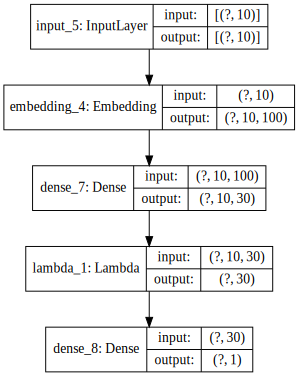

In [19]:
# model
model = get_deepset_model(max_train_length)

with open("deepsets_architecture.pdf", "wb") as text_file:
    text_file.write(model_to_dot(model, show_shapes=True, dpi=70).create(prog='dot', format='pdf'))
# visualize
SVG(model_to_dot(model, show_shapes=True, dpi=70).create(prog='dot', format='svg'))

In [20]:
# train
checkpointer = ModelCheckpoint(filepath='/tmp/weights.hdf5', verbose=0, save_best_only=True)

model.fit(X, sum_X, epochs=10, batch_size=128,
        shuffle=True, validation_split=0.0123456789,
        callbacks=[checkpointer])

model = load_model('/tmp/weights.hdf5')

# save weights
deep_we = []
for i in [1,2,4]:
    w = model.get_layer(index=i).get_weights()
    deep_we.append(w)

# # train
# # checkpointer = ModelCheckpoint(filepath='/tmp/weights.hdf5', verbose=0, save_best_only=True)

# # model.fit(X, sum_X, epochs=10, batch_size=128,
# #         shuffle=True, validation_split=0.0123456789,
# #         callbacks=[checkpointer])

# # model = load_model('/tmp/weights.hdf5')

# # save weights
# deep_we = []
# for i in [2]:
#     w = model.get_layer(index=i).get_weights()
#     print(np.array(w))
#     print(np.array(w[0]).shape)
#     try:
# #         print(np.array(w)[0,0])
#         print(np.array(w[1]).shape)
#         print(np.array(w[2]).shape)
#     except:
#         pass
#     print(20*"-")
#     deep_we.append(w)

Epoch 1/10
772/772 [==============================] - 2s 2ms/step - loss: 13.6343 - val_loss: 3.6717
Epoch 2/10
772/772 [==============================] - 2s 2ms/step - loss: 1.4356 - val_loss: 0.1088
Epoch 3/10
772/772 [==============================] - 2s 2ms/step - loss: 0.0181 - val_loss: 0.0053
Epoch 4/10
772/772 [==============================] - 2s 2ms/step - loss: 0.0076 - val_loss: 0.0035
Epoch 5/10
772/772 [==============================] - 2s 2ms/step - loss: 0.0075 - val_loss: 0.0189
Epoch 6/10
772/772 [==============================] - 2s 2ms/step - loss: 0.0076 - val_loss: 0.0028
Epoch 7/10
772/772 [==============================] - 2s 2ms/step - loss: 0.0072 - val_loss: 0.0039
Epoch 8/10
772/772 [==============================] - 2s 2ms/step - loss: 0.0070 - val_loss: 0.0145
Epoch 9/10
772/772 [==============================] - 2s 2ms/step - loss: 0.0089 - val_loss: 0.0075
Epoch 10/10
772/772 [==============================] - 2s 2ms/step - loss: 0.0071 - val_loss: 0.002

# Train LSTM model

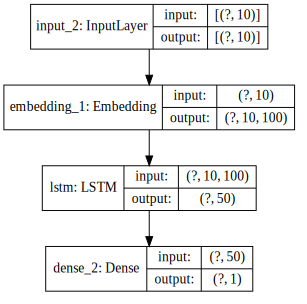

In [13]:
# model
model = get_lstm_model(max_train_length)

with open("lstm_architecture.pdf", "wb") as text_file:
    text_file.write(model_to_dot(model, show_shapes=True, dpi=70).create(prog='dot', format='pdf'))
# visualize
SVG(model_to_dot(model, show_shapes=True, dpi=70).create(prog='dot', format='svg'))

In [14]:
# train
checkpointer = ModelCheckpoint(filepath='/tmp/weights1.hdf5', verbose=0, save_best_only=True)

model.fit(X, sum_X, epochs=50, batch_size=128,
        shuffle=True, validation_split=0.0123456789,
        callbacks=[checkpointer])

model = load_model('/tmp/weights1.hdf5')

# save weights
lstm_we = []
for i in [1,2,3]:
    w = model.get_layer(index=i).get_weights()
    lstm_we.append(w)

Epoch 1/50
772/772 [==============================] - 12s 15ms/step - loss: 18.6242 - val_loss: 13.9351
Epoch 2/50
772/772 [==============================] - 9s 11ms/step - loss: 12.6424 - val_loss: 10.9236
Epoch 3/50
772/772 [==============================] - 8s 11ms/step - loss: 10.1117 - val_loss: 8.6208
Epoch 4/50
772/772 [==============================] - 8s 11ms/step - loss: 7.9299 - val_loss: 6.6516
Epoch 5/50
772/772 [==============================] - 9s 11ms/step - loss: 6.1621 - val_loss: 5.0931
Epoch 6/50
772/772 [==============================] - 9s 11ms/step - loss: 4.6920 - val_loss: 3.7571
Epoch 7/50
772/772 [==============================] - 9s 11ms/step - loss: 3.4657 - val_loss: 2.7218
Epoch 8/50
772/772 [==============================] - 8s 11ms/step - loss: 2.5316 - val_loss: 1.9431
Epoch 9/50
772/772 [==============================] - 9s 12ms/step - loss: 1.8346 - val_loss: 1.3838
Epoch 10/50
772/772 [==============================] - 9s 12ms/step - loss: 1.3258 - 

# Train GRU model

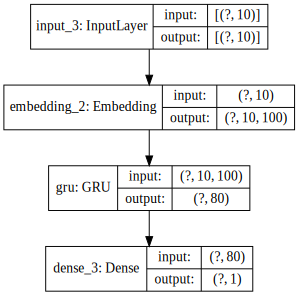

In [15]:
# model
model = get_gru_model(max_train_length)

with open("gru_architecture.pdf", "wb") as text_file:
    text_file.write(model_to_dot(model, show_shapes=True, dpi=70).create(prog='dot', format='pdf'))
# visualize
SVG(model_to_dot(model, show_shapes=True, dpi=70).create(prog='dot', format='svg'))

In [16]:
# train
checkpointer = ModelCheckpoint(filepath='/tmp/weights2.hdf5', verbose=0, save_best_only=True)

model.fit(X, sum_X, epochs=50, batch_size=128,
        shuffle=True, validation_split=0.0123456789,
        callbacks=[checkpointer])

model = load_model('/tmp/weights2.hdf5')

# save weights
gru_we = []
for i in [1,2,3]:
    w = model.get_layer(index=i).get_weights()
    gru_we.append(w)

Epoch 1/50
772/772 [==============================] - 13s 17ms/step - loss: 15.2685 - val_loss: 10.2594
Epoch 2/50
772/772 [==============================] - 10s 13ms/step - loss: 8.8410 - val_loss: 6.9567
Epoch 3/50
772/772 [==============================] - 11s 14ms/step - loss: 5.9344 - val_loss: 4.3267
Epoch 4/50
772/772 [==============================] - 14s 18ms/step - loss: 3.6149 - val_loss: 2.5253
Epoch 5/50
772/772 [==============================] - 13s 17ms/step - loss: 2.1815 - val_loss: 1.5135
Epoch 6/50
772/772 [==============================] - 13s 16ms/step - loss: 1.3413 - val_loss: 0.9195
Epoch 7/50
772/772 [==============================] - 12s 15ms/step - loss: 0.8408 - val_loss: 0.5813
Epoch 8/50
772/772 [==============================] - 12s 15ms/step - loss: 0.5485 - val_loss: 0.3791
Epoch 9/50
772/772 [==============================] - 12s 15ms/step - loss: 0.3747 - val_loss: 0.2609
Epoch 10/50
772/772 [==============================] - 12s 15ms/step - loss: 0.2

# Train Vanilla Model

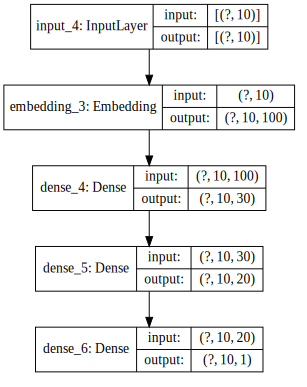

In [17]:
# model
model = get_vanilla_model(max_train_length)

# visualize
SVG(model_to_dot(model, show_shapes=True, dpi=70).create(prog='dot', format='svg'))

In [ ]:
# train
checkpointer = ModelCheckpoint(filepath='/tmp/weights2.hdf5', verbose=0, save_best_only=True)

model.fit(X, sum_X, epochs=50, batch_size=128,
        shuffle=True, validation_split=0.0123456789,
        callbacks=[checkpointer])

model = load_model('/tmp/weights2.hdf5')

# save weights
vanilla_we = []
for i in [1,2,3,4]:
    w = model.get_layer(index=i).get_weights()
    vanilla_we.append(w)

# Evaluate models

In [21]:
metrics = {'deepsets': {'acc':[], 'mae':[], 'mse':[]}, 'lstm': {'acc':[], 'mae':[], 'mse':[]}, 'gru': {'acc':[], 'mae':[], 'mse':[]}, 'vanilla': {'acc':[], 'mae':[], 'mse':[]}}

lengths = range(min_test_length, max_test_length, step_test_length)
for l in lengths:
    print('Evaluating at length: ', l)
    K.clear_session()
    
    # generate test data
    Y, sum_Y = gen_test_data(num_test_examples, l)

    # model
    model = get_deepset_model(l)

    # load weights
    for i, idx in enumerate([1,2,4]):
        model.get_layer(index=idx).set_weights(deep_we[i])

    # prediction
    preds = model.predict(Y, batch_size=128, verbose=1)
    metrics['deepsets']['acc'].append(1.0*np.sum(np.squeeze(np.round(preds))==sum_Y)/len(sum_Y))
    metrics['deepsets']['mae'].append(np.sum(np.abs(np.squeeze(preds)-sum_Y))/len(sum_Y))
    metrics['deepsets']['mse'].append(np.dot(np.squeeze(preds)-sum_Y, np.squeeze(preds)-sum_Y)/len(sum_Y))
    
    # model
    model = get_lstm_model(l)

    # load weights
    for i, idx in enumerate([1,2,3]):
        model.get_layer(index=idx).set_weights(lstm_we[i])

    # prediction
    preds = model.predict(Y, batch_size=128, verbose=1)
    metrics['lstm']['acc'].append(1.0*np.sum(np.squeeze(np.round(preds))==sum_Y)/len(sum_Y))
    metrics['lstm']['mae'].append(np.sum(np.abs(np.squeeze(preds)-sum_Y))/len(sum_Y))
    metrics['lstm']['mse'].append(np.dot(np.squeeze(preds)-sum_Y, np.squeeze(preds)-sum_Y)/len(sum_Y))
    
    # model
    model = get_gru_model(l)

    # load weights
    for i, idx in enumerate([1,2,3]):
        model.get_layer(index=idx).set_weights(gru_we[i])

    # prediction
    preds = model.predict(Y, batch_size=128, verbose=1)
    metrics['gru']['acc'].append(1.0*np.sum(np.squeeze(np.round(preds))==sum_Y)/len(sum_Y))
    metrics['gru']['mae'].append(np.sum(np.abs(np.squeeze(preds)-sum_Y))/len(sum_Y))
    metrics['gru']['mse'].append(np.dot(np.squeeze(preds)-sum_Y, np.squeeze(preds)-sum_Y)/len(sum_Y))
    

Evaluating at length:  5
79/79 [==============================] - 0s 3ms/step
Evaluating at length:  10
79/79 [==============================] - 1s 7ms/step
Evaluating at length:  15
79/79 [==============================] - 1s 8ms/step
Evaluating at length:  20
79/79 [==============================] - 1s 9ms/step
Evaluating at length:  25
79/79 [==============================] - 1s 12ms/step
Evaluating at length:  30
79/79 [==============================] - 1s 16ms/step
Evaluating at length:  35
79/79 [==============================] - 1s 18ms/step
Evaluating at length:  40
79/79 [==============================] - 2s 20ms/step
Evaluating at length:  45
79/79 [==============================] - 2s 24ms/step
Evaluating at length:  50
79/79 [==============================] - 2s 25ms/step
Evaluating at length:  55
79/79 [==============================] - 2s 30ms/step
Evaluating at length:  60
79/79 [==============================] - 2s 30ms/step
Evaluating at length:  65
79/79 [============

In [ ]:
print('Evaluating at length: ', 10)
K.clear_session()

# generate test data
Y, sum_Y = gen_test_data(num_test_examples, 10)

# model
model = get_vanilla_model(10)

# load weights
for i, idx in enumerate([1,2,3]):
    model.get_layer(index=idx).set_weights(vanilla_we[i])

# prediction
preds = model.predict(Y, batch_size=128, verbose=1)
metrics['vanilla']['acc'].append(1.0*np.sum(np.squeeze(np.round(preds))==sum_Y)/len(sum_Y))
metrics['vanilla']['mae'].append(np.sum(np.abs(np.squeeze(preds)-sum_Y))/len(sum_Y))
metrics['vanilla']['mse'].append(np.dot(np.squeeze(preds)-sum_Y, np.squeeze(preds)-sum_Y)/len(sum_Y))

Compare the performance

In [24]:
from matplotlib import rc
# activate latex text rendering
rc('text', usetex=True)
import matplotlib
# matplotlib.use('QT5Agg')
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'font.size' : 14,
    'text.usetex': True,
    'pgf.rcfonts': False,
    'axes.unicode_minus': False,
})
matplotlib.rcParams['text.latex.preamble'] = r'\DeclareUnicodeCharacter{2212}{-}' #for \text command

import matplotlib.pyplot as plt

# font = {'size': 14}
# matplotlib.rc('font', **font)

scale = 0.5
plt.figure(figsize=(10*scale, 8*scale))
print(metrics['deepsets']['acc'])
plt.plot(lengths, metrics['deepsets']['acc'], 'o-')
plt.plot(lengths, metrics['lstm']['acc'], 'o-')
plt.plot(lengths, metrics['gru']['acc'], 'o-')
print(metrics['vanilla']['acc'])
plt.xlabel('Number of digits to add')
plt.ylabel('Accuracy')
plt.title('Accuracy of DeepSets, LSTM, and GRU')
plt.ylim( 0, 1.1 )
plt.xlim( 5, 95 )
plt.legend(['Deepsets', 'LSTM', 'GRU'], fontsize=14)
plt.tight_layout()
plt.savefig('blabla.pgf')
plt.show()

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[]


<ipython-input-24-aec9532fea70>:37: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()
